In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:


class GeneticAlgorithm():
    """
    Класс реализующий генетический алгоритм

    ...

    Methods
    -------
    estimate_fitness()
        метод оценки значения приспособленности
    crossover()
        оператор скрещивания
    mutation()
        оператор мутации
    keep_bounds()
        метод для выравнивания значений аргументов по заданным границам
    stop_criterion()
        метод с критериями останова
    run()
        метод для запуска оптимизации
    """
    
    def __init__(self,
                 opt_function,
                 num_args,
                 data,
                 population_size = 100,
                 crossover_rate = 0.5,
                 mutation_probability = 0.05,
                 max_num_iteration = 1e5,
                 max_num_iteration_without_improvement = 10,
                 tolerance = 1e-5,
                 args_bounds = None
                ):
                 
        """
        Parameters
        ----------
        opt_function : function
            оптимизируемая функция
        num_args : int
            количество аргументов у opt_function
        data : undefined
            данные необходимые для расчета функционала 
        population_size : int
            количество особей
        crossover_rate : float [0, 1]
            процент скрещивающихся особей
        mutation_probability : float [0, 1]
            вероятность мутации
        max_num_iteration : int or None
            максимальное количество итераций
        max_num_iteration_without_improvement : int
            максимальное количество последовательных итераций без улучшения результата
        tolerance : float
            минимальное значение уменьшения стандартного отклонения от best_score_history,  
            при котором продолжаются расчеты
        args_bounds : None or list of tuples
            содержит кортежи с мин и макс значениями для каждого аргумента opt_function
            если None, тогда выбираются стандартные границы
        best_score_history : list
            список с историей лучших результатов популяции на каждой итерации
        soltuion : dict
            словарь с аргументами и значением функции для лучшего решения
        """
        
        self.opt_function = opt_function
        self.num_args = num_args
        self.data = data
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_probability = mutation_probability
        self.max_num_iteration = int(max_num_iteration)
        self.max_num_iteration_without_improvement = int(max_num_iteration_without_improvement)
        self.tolerance = tolerance
        self.args_bounds = args_bounds
        self.best_score_history = []
        self.solution = {}
        
        
    def estimate_fitness(self, x):
        """Метод оценивает приспособленность особи
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        score : float
            значение функции приспособленности
        """
        score = self.opt_function(x, self.data)
            
        return score
                 
    def crossover(self, x_parent, y_parent):
        """Метод для случайного скрещивания двух родительских особей, возвращает две потомственные особи
        
        Parameters
        ----------
        x_parent : np.array
            1ая родительская особь
        y_parent : np.array
            2ая родительская особь
            
        Returns
        ------
        x_child : np.array
            1ая потомственная особь
        y_child : np.array
            2ая потомственная особь
        """
        
        x_child = x_parent.copy()
        y_child = y_parent.copy()
                    
        for i in range(self.num_args):
            alpha = np.random.rand()
            x_child[i] = x_parent[i] + alpha * (y_parent[i] - x_parent[i])
            
            alpha = np.random.rand()
            y_child[i] = x_parent[i] + alpha * (x_parent[i] - y_parent[i])
                   
        return x_child, y_child
                 
    
    def mutation(self, x):
        """Метод для мутации особи меняет значения генов случайным образом
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        for i in range(self.num_args):
            if self.args_bounds is None:
                alpha = np.random.uniform(-1.0, 1.0)
            else:
                alpha = np.random.uniform(self.args_bounds[i][0], self.args_bounds[i][1])
            x_new[i] = x_new[i] + alpha
            
        return x_new
    
    
#     def selection(self, ):
    
    
    def keep_bounds(self, x):
        """Метод ограничивает область значений аргументов
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        if self.args_bounds is None:
            return x_new
                       
        for i in range(self.num_args):
            # если x_i меньше минимума, тогда присваиваем значение минимума
            if x_new[i] < self.args_bounds[i][0]:
                x_new[i] = self.args_bounds[i][0]
            # если x_i больше максимума, тогда присваиваем значение максимума
            if x_new[i] > self.args_bounds[i][1]:
                x_new[i] = self.args_bounds[i][1]
            
        return x_new
           
        
    def stop_criterion(self, i):
        """В методе реализованы критерии останова
        
        Parameters
        ----------
        i : int
            номер итерации
            
        Returns
        ------
        True / False
            если хотя бы один из критериев срабатывает, то возвращает True        
        """
            
        # если стандартное отклонение best_score_history уменьшается меньше, чем на tolerance 
        rolling_std = [np.std(self.best_score_history[:i+1]) for i in range(3, len(self.best_score_history))]
        rolling_std = np.array(rolling_std)
        std_change = np.diff(rolling_std)[-1] / rolling_std[-2]
        if std_change < self.tolerance:
            print("std stop-criterion")
            return True
        
        # если количество итераций превышает максимальное
        if i > self.max_num_iteration - 1:
            print("max number of iteration stop-criterion")
            return True
        
        # если best_score не улучшается более max_num_iteration_without_improvement итераций
        n = self.max_num_iteration_without_improvement
        best_score_changes = np.sign(np.diff(self.best_score_history))[-n:]
        if not -1 in best_score_changes:
            print("max number of iteration without improvement stop-criterion")
            return True
            
        return False 
        
        
    def run(self):
        
        # создаем начальную популяцию
        population = []
        for i in range(self.population_size):
            args_individual = np.zeros(self.num_args)
            # нормируем значения аргументов к границам args_bounds, если они заданы
            for n in range(self.num_args):
                if self.args_bounds is None:
                    args_individual[n] = np.random.uniform(-1.0, 1.0)
                else:
                    args_individual[n] = np.random.uniform(self.args_bounds[n][0], self.args_bounds[n][1])
                    
            # вычисляем приспособленность особи
            score = self.estimate_fitness(args_individual)
            individual = {'args':args_individual, 'score':score}
            population.append(individual)
           
        stop = False
        i = 0
        # запускаем алгоритм
        while not stop:
            
            # СКРЕЩИВАНИЕ
            parents_population = population[:int(len(population) * self.crossover_rate)]
            childs_population = []
            for x_parent in parents_population:
                # находим пару для каждой особи и проводим скрещиванием
                y_parent = np.random.choice(parents_population)
                x_child_args, y_child_args = self.crossover(x_parent['args'], y_parent['args'])
                x_child = {'args':x_child_args, 'score':None}
                y_child = {'args':y_child_args, 'score':None}
                childs_population.append(x_child)
                childs_population.append(y_child)
            # добавляем новых потомков в популяцию
            population += childs_population

            # МУТАЦИИ
            for ind, x in enumerate(population):
                # проверяем условие вероятности мутации
                if np.random.rand() < self.mutation_probability:
                    population[ind]['args'] = self.mutation(x['args'])
            
            # ОЦЕНКА ПРИСПОСОБЛЕННОСТИ
            for ind in range(len(population)):
                population[ind]['args'] = self.keep_bounds(population[ind]['args'])
                population[ind]['score'] = self.estimate_fitness(population[ind]['args'])
                
            # ОТБОР
            self.population = population
            population = sorted(population, key=lambda item: item['score'])
            population = population[:self.population_size]
            
            # записываем best_score 
            best_score = population[0]['score']
            self.best_score_history.append(best_score)
            
            if i > 10:
                stop = self.stop_criterion(i)
            
            i += 1
            
        self.solution = population[0]
            

In [3]:
def stupid_backtest(df):
    """В функции реализован простейший бэктест
        без учета комиссий, проскальзываний, задержек и всего что нужно учитывать
        
        Parameters
        ----------
        df : pd.DataFrame
            датафрейм содержащий ряды signal и Close
            
        Returns
        ------
        df : pd.DataFrame
            исходный датафрейм с пнлем
        """
    
    df['pnl'] = (df['Close'].diff() * df['signal'].shift()).cumsum()
    
    return df

In [4]:

df = pd.read_csv('sp500.csv', sep=';')
df['Date'] = pd.to_datetime(df['Date'], format='%b %d %Y')
df.set_index('Date', inplace=True)
df.sort_values(by='Date', inplace=True)

df = df[['Close*']]
df.columns = ['Close']


df['log_return'] = np.log(df['Close'] / df['Close'].shift()).cumsum()
df['dd_log'] = df['log_return'] - df['log_return'].rolling(len(df), min_periods=1).max()


def opt_1(x, df):    
    """Функционал для оптимизации
        
        Parameters
        ----------
        x : np.array
            значения аргументов, по которым рассчитывается значение функционала
        df : pd.DataFrame
            датафрейм содержащий ряды signal, Close и dd_log
            
        Returns
        ------
        f : float
            значение функционала
        """
    dd_level = x[0]

    df['signal'] = np.nan
    df.loc[df['dd_log'] < dd_level, 'signal'] = 1
    df.loc[df['dd_log'] == 0, 'signal'] = 0
    df['signal'].ffill(inplace=True)
    
    df = stupid_backtest(df)
    
    # просто максимум профита
    f = -df['pnl'].iloc[-1]
    
    return f
    

In [5]:
ga = GeneticAlgorithm(opt_1, 1, df, args_bounds=[(-0.8, -0.05)])
ga.run()

print(ga.solution)


std stop-criterion
{'args': array([-0.41359531]), 'score': -2271.03}


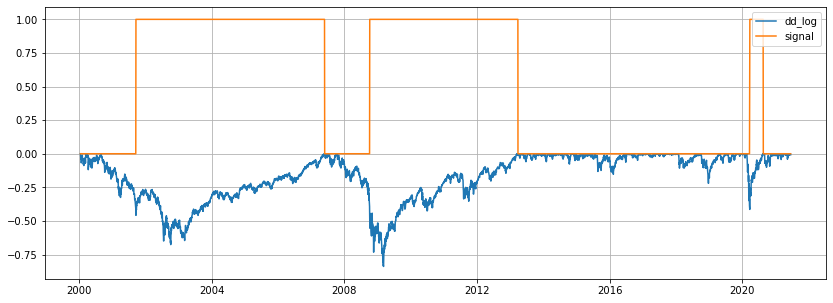

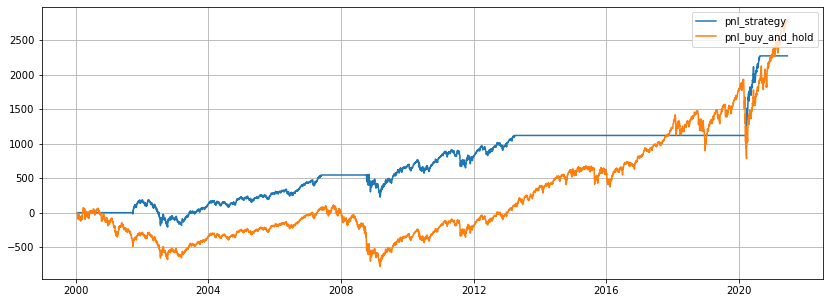

In [6]:
dd_level = ga.solution['args'][0]

df['signal'] = np.nan
df.loc[df['dd_log'] < dd_level, 'signal'] = 1
df.loc[df['dd_log'] == 0, 'signal'] = 0
df['signal'].ffill(inplace=True)

df = stupid_backtest(df)

plt.figure(figsize=(14,5))
plt.plot(df['dd_log'], label='dd_log')
plt.plot(df['signal'], label='signal')
plt.grid()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df['pnl'], label='pnl_strategy')
plt.plot(df['Close'] - df['Close'].iloc[0], label='pnl_buy_and_hold')
plt.grid()
plt.legend(loc='upper right')
plt.show()